# **DSCI 100 Project Final Report**


## **Introduction**
### Background Information
In this project, we are exploring data gathered from Minecraft players. The Minecraft server is set up by a computer science research group led by Frank Wood, and they are trying to figure out what kind of players should be targeted for recruiting based on whose most likely to contribute largest amounts of data.

### Question of the Project
Based on the goals of the research group, the question we are trying to answer is: **Can Player Age Predict the Total Number of Gameplay Sessions Contributed?**

### Loading Data 
Below is the initial loading of both datasets, as well as `summary()` being run on both.

In [1]:
library(tidyverse)
players_data <- read_csv("Data/players.csv")
head(players_data)
summary(players_data)
sessions_data <- read_csv("Data/sessions.csv")
head(sessions_data)
summary(sessions_data)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
Rows: 196 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, Age
lgl (1): subscribe

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


experience,subscribe,hashedEmail,played_hours,name,gender,Age
<chr>,<lgl>,<chr>,<dbl>,<chr>,<chr>,<dbl>
Pro,TRUE,f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,30.3,Morgan,Male,9
Veteran,TRUE,f3c813577c458ba0dfef80996f8f32c93b6e8af1fa939732842f2312358a88e9,3.8,Christian,Male,17
Veteran,FALSE,b674dd7ee0d24096d1c019615ce4d12b20fcbff12d79d3c5a9d2118eb7ccbb28,0.0,Blake,Male,17
Amateur,TRUE,23fe711e0e3b77f1da7aa221ab1192afe21648d47d2b4fa7a5a659ff443a0eb5,0.7,Flora,Female,21
Regular,TRUE,7dc01f10bf20671ecfccdac23812b1b415acd42c2147cb0af4d48fcce2420f3e,0.1,Kylie,Male,21
Amateur,TRUE,f58aad5996a435f16b0284a3b267f973f9af99e7a89bee0430055a44fa92f977,0.0,Adrian,Female,17


  experience        subscribe       hashedEmail         played_hours    
 Length:196         Mode :logical   Length:196         Min.   :  0.000  
 Class :character   FALSE:52        Class :character   1st Qu.:  0.000  
 Mode  :character   TRUE :144       Mode  :character   Median :  0.100  
                                                       Mean   :  5.846  
                                                       3rd Qu.:  0.600  
                                                       Max.   :223.100  
                                                                        
     name              gender               Age       
 Length:196         Length:196         Min.   : 9.00  
 Class :character   Class :character   1st Qu.:17.00  
 Mode  :character   Mode  :character   Median :19.00  
                                       Mean   :21.14  
                                       3rd Qu.:22.75  
                                       Max.   :58.00  
                               

Rows: 1535 Columns: 5
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (3): hashedEmail, start_time, end_time
dbl (2): original_start_time, original_end_time

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


hashedEmail,start_time,end_time,original_start_time,original_end_time
<chr>,<chr>,<chr>,<dbl>,<dbl>
bfce39c89d6549f2bb94d8064d3ce69dc3d7e72b38f431d8aa0c4bf95ccee6bf,30/06/2024 18:12,30/06/2024 18:24,1.71977e+12,1.71977e+12
36d9cbb4c6bc0c1a6911436d2da0d09ec625e43e6552f575d4acc9cf487c4686,17/06/2024 23:33,17/06/2024 23:46,1.71867e+12,1.71867e+12
f8f5477f5a2e53616ae37421b1c660b971192bd8ff77e3398304c7ae42581fdc,25/07/2024 17:34,25/07/2024 17:57,1.72193e+12,1.72193e+12
bfce39c89d6549f2bb94d8064d3ce69dc3d7e72b38f431d8aa0c4bf95ccee6bf,25/07/2024 03:22,25/07/2024 03:58,1.72188e+12,1.72188e+12
36d9cbb4c6bc0c1a6911436d2da0d09ec625e43e6552f575d4acc9cf487c4686,25/05/2024 16:01,25/05/2024 16:12,1.71665e+12,1.71665e+12
bfce39c89d6549f2bb94d8064d3ce69dc3d7e72b38f431d8aa0c4bf95ccee6bf,23/06/2024 15:08,23/06/2024 17:10,1.71916e+12,1.71916e+12


 hashedEmail         start_time          end_time         original_start_time
 Length:1535        Length:1535        Length:1535        Min.   :1.712e+12  
 Class :character   Class :character   Class :character   1st Qu.:1.716e+12  
 Mode  :character   Mode  :character   Mode  :character   Median :1.719e+12  
                                                          Mean   :1.719e+12  
                                                          3rd Qu.:1.722e+12  
                                                          Max.   :1.727e+12  
                                                                             
 original_end_time  
 Min.   :1.712e+12  
 1st Qu.:1.716e+12  
 Median :1.719e+12  
 Mean   :1.719e+12  
 3rd Qu.:1.722e+12  
 Max.   :1.727e+12  
 NA's   :2          

## The Datasets: `player.csv` and `sessions.csv`
The data sets are provided as follows

### `players.csv` is a list of all unique players, including data about each player. 
We use the data in the `Age` column as an explanatory variable in our question.
  
#### `players_data` Summary
In the `players.csv` dataset, there are
* 196 observations
* 7 variables
* `played_hours` and possibly `hashed_email` is gathered through server data, and every other variable likely through registration/survey
  

##### Variables Summary
The 7 variables are 
1. `experience`
   * character variable with 5 categories: "Veteran", "Pro", "Amateur", "Regular", and "Beginning", indicating individuals' MineCraft experience level
<br><br>     
2. `subscribe`
   * logical variable (`true` or `false`) indicating player's subscription to a newsletter
   * there are many more subscribers (144) to non-subscribers (52)
<br><br>
3. `hashedEmail`
   * character variable that reports the player's censored email address
   * **potential issue:** undecipherable to reader
<br><br>
4. `played_hours`
    * a double variable reporting an individual's played hours of MineCraft
    * **mean played_hours: 5.84** 
<br><br>
5. `name`
   * character variable of player's name
<br><br>
6. `gender`
   * character variable representing the player's gender: "Male", "Female", "Agender", "Prefer not to say", "Non-binary","Other" and "Two-Spirited."
   * **potential issue:** must become factors
<br><br>
7. `age`
    * double variable reporting the individual's age in years
    * **potential issue:** `NA` values must be filtered out
    * **mean age: 21.14**
<br><br>

### `sessions.csv` is a list of individual play sessions by each player, including data about the session. 
We used data from the `hashedEmail` column to serve as the response variable, an individual's number of game sessions played, for the predictor, `Age`. 
#### `sessions_data` Summary
In the `sessions.csv` dataset, there are
* 1535 observations
* 5 variables
* all data came from the MineCraft server
  

#### Variables Summary
The 5 variables are 
1. `hashedEmail` (repeat from `players.csv`)
   * character variable that reports the player's censored email address
<br><br>
2. `start_time` and `end_time`
    * both character variables
    * **potential issues**: not tidy data (characters), but understandable to reader
<br><br>
3. `original_start_time` and `original_end_time`
     * both double variables
     * **potential issues**: unintelligible to reader
    * **mean `original_start_time`: 1.719e+12**
    * **mean `original_end_time`: 1.719e+12**
    * **potential issue:** NA values present in `original_end_time`


## **Methods & Results**

In [2]:
library(tidyverse)
library(tidymodels)
library(knitr)
library(repr)
library(cowplot)

── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.6     ✔ rsample      1.2.1
✔ dials        1.3.0     ✔ tune         1.1.2
✔ infer        1.0.7     ✔ workflows    1.1.4
✔ modeldata    1.4.0     ✔ workflowsets 1.0.1
✔ parsnip      1.2.1     ✔ yardstick    1.3.1
✔ recipes      1.1.0     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() masks readr::spec()
✖ recipes::step()   masks stats::step()
• Use tidymodels_prefer() to resolve common conflicts.


Attaching package: ‘cowplot’


The following object is masked from ‘package:lubridate’:

    stamp




### Data Wrangling and Cleaning

In [3]:
# Count sessions per player
session_counts <- sessions_data |>
  filter(!is.na(end_time)) |>
  group_by(hashedEmail) |>
  summarise(num_sessions = n())

# Join with player data and clean
analysis_data <- players_data |>
  left_join(session_counts, by = "hashedEmail") |>
  mutate(
    num_sessions = replace_na(num_sessions, 0),
    Age = as.numeric(Age)
  ) |>
  filter(!is.na(Age))

# Display summary
cat("Cleaned dataset contains", nrow(analysis_data), "players with complete age data\n")
cat("Players with at least one session:", sum(analysis_data$num_sessions > 0), "\n")

Cleaned dataset contains 194 players with complete age data
Players with at least one session: 123 


We performed the following data wrangling steps to prepare our dataset for analysis:

1. **Filtered incomplete sessions**: We removed sessions with missing end times from the sessions dataset
2. **Counted sessions per player**: We grouped the sessions data by each player's hashed email and counted how many sessions they had
3. **Joined datasets**: We combined the session counts with the player demographic data using the hashed email as the key
4. **Handled missing sessions**: Players who had no recorded sessions were assigned a count of 0
5. **Removed missing age values**: We filtered out players who did not have age data, leaving us with 194 players for analysis

This cleaned dataset contains all the information needed to explore whether player age can predict the number of gameplay sessions contributed.

### Summary Statistics for Exploratory Data Analysis

In [4]:
# Calculate summary statistics for Age
age_summary <- data.frame(
  Variable = "Age (years)",
  Mean = round(mean(analysis_data$Age, na.rm = TRUE), 2),
  SD = round(sd(analysis_data$Age, na.rm = TRUE), 2),
  Min = round(min(analysis_data$Age, na.rm = TRUE), 2),
  Max = round(max(analysis_data$Age, na.rm = TRUE), 2)
)

# Calculate summary statistics for Number of Sessions
sessions_summary <- data.frame(
  Variable = "Number of Sessions",
  Mean = round(mean(analysis_data$num_sessions), 2),
  SD = round(sd(analysis_data$num_sessions), 2),
  Min = round(min(analysis_data$num_sessions), 2),
  Max = round(max(analysis_data$num_sessions), 2)
)

# Combine into one table
summary_table <- rbind(age_summary, sessions_summary)
kable(summary_table, caption = "Table 1: Summary Statistics for Age and Session Count")

# Additional relevant statistics
cat("\n**Key Statistics:**\n")
cat("- Correlation between Age and Sessions:", 
    round(cor(analysis_data$Age, analysis_data$num_sessions), 3), "\n")
cat("- Percentage of players with 0 sessions:", 
    round(sum(analysis_data$num_sessions == 0) / nrow(analysis_data) * 100, 1), "%\n")
cat("- Percentage of players with 10+ sessions:", 
    round(sum(analysis_data$num_sessions >= 10) / nrow(analysis_data) * 100, 1), "%\n")



Table: Table 1: Summary Statistics for Age and Session Count

|Variable           |  Mean|    SD| Min| Max|
|:------------------|-----:|-----:|---:|---:|
|Age (years)        | 21.14|  7.39|   9|  58|
|Number of Sessions |  7.89| 33.64|   0| 310|


**Key Statistics:**
- Correlation between Age and Sessions: -0.055 
- Percentage of players with 0 sessions: 36.6 %
- Percentage of players with 10+ sessions: 8.8 %


The summary statistics reveal important patterns in our dataset. Players range from 9 to 58 years old, with an average age of about 21 years. The number of sessions varies widely, from 0 to over 300 sessions, though most players have relatively few sessions (mean = 7.89). 

The correlation between age and sessions is very weak (-0.055), suggesting that age alone may not be a strong predictor of player engagement. Additionally, we see that a significant portion of players (about 37%) have zero sessions, while only a small percentage are highly engaged players with 10 or more sessions. This initial exploration suggests we should be cautious about expecting a strong predictive relationship between age and session count.

### Exploratory Data Visualization

`geom_smooth()` using formula = 'y ~ x'


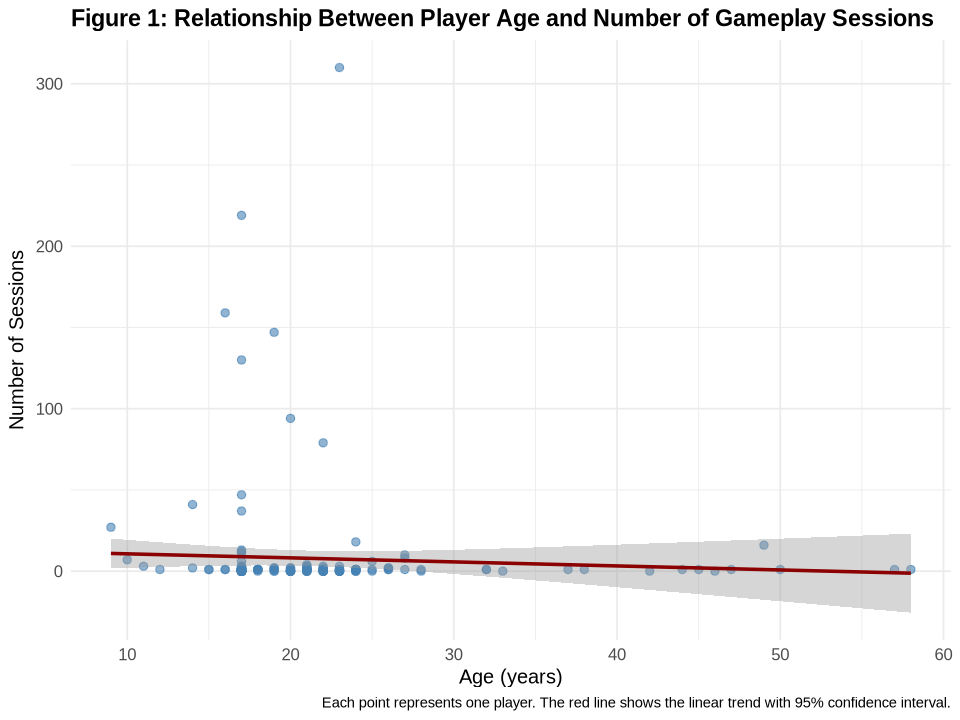

In [5]:
# Set figure size for better readability
options(repr.plot.width = 8, repr.plot.height = 6)

# Create scatter plot with regression line
ggplot(analysis_data, aes(x = Age, y = num_sessions)) +
  geom_point(alpha = 0.6, color = "steelblue", size = 2) +
  geom_smooth(method = "lm", se = TRUE, color = "darkred", linewidth = 1) +
  labs(
    title = "Figure 1: Relationship Between Player Age and Number of Gameplay Sessions",
    x = "Age (years)",
    y = "Number of Sessions",
    caption = "Each point represents one player. The red line shows the linear trend with 95% confidence interval."
  ) +
  theme_minimal() +
  theme(
    plot.title = element_text(size = 14, face = "bold"),
    axis.title = element_text(size = 12),
    axis.text = element_text(size = 10)
  )

Figure 1 shows the relationship between player age and the number of gameplay sessions contributed to the research server. Most players cluster near the bottom of the plot with fewer than 25 sessions, regardless of age. The nearly horizontal regression line (with a slight negative slope) indicates a very weak relationship between age and session count. 

While there are some notable outliers, particularly younger players (ages 15-25) with over 100 sessions, these high-engagement players appear across various ages. The wide confidence interval around the regression line further suggests substantial variability and uncertainty in predicting sessions based solely on age. This visual evidence supports our earlier finding from the correlation analysis that age may not be a strong predictor of player contribution to the research dataset.

Our analysis is focused on predicting contribution using age, however it is important to look at which age groups are more likely to participate at all before we begin.

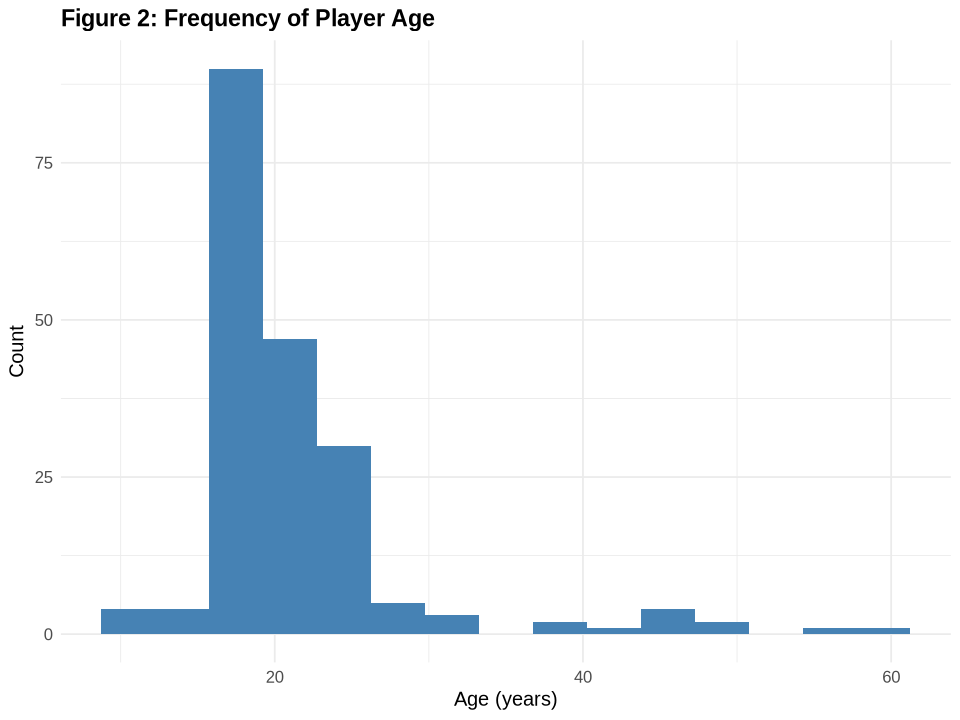

In [6]:
# Set figure size for better readability
options(repr.plot.width = 8, repr.plot.height = 6)

# Create histogram
ggplot(analysis_data, aes(x = Age)) +
  geom_histogram(fill = "steelblue", bins = 15) +

  labs(
    title = "Figure 2: Frequency of Player Age",
    x = "Age (years)",
    y = "Count") +
  theme_minimal() +
  theme(
    plot.title = element_text(size = 14, face = "bold"),
    axis.title = element_text(size = 12),
    axis.text = element_text(size = 10)
  )

Figure 2 shows the distribution of players by age, it is right skewed with a peak around 15 years old. This tells us that younger players, especially those under 25 years old, are more likely to participate in the study. 

## KNN Regression Analysis

Due to the non-linear relationship between age and number of sessions, the K-NN regression method is better for our analysis than linear regression, which would be better if Figure 1 demonstrated a more linear trend in the data. Additionally, there is high variability in number of sessions played, with some potential outliers over 100 sessions, as visualized in Figure 1.

First, we split the data into training and testing sets. We chose a 0.75 training / 0.25 testing split. We need to reserve enough data entries for testing, but still leave a lot for accurate training, which is why this split was chosen.

In [7]:
# set seed for reproducibility
set.seed(5000)

analysis_split <- initial_split(analysis_data, prop = 0.75, strata = num_sessions)
analysis_training <- training(analysis_split)
analysis_testing <- testing(analysis_split)


# create model specification
analysis_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |> 
      set_engine("kknn") |>
      set_mode("regression")

# create recipe
# response variable is num_sessions
# predictor is Age of player
analysis_recipe <- recipe(num_sessions ~ Age, data = analysis_training) |>
      step_scale(all_predictors()) |>
      step_center(all_predictors())

Now that we have created the model specification and recipe, we can use cross-validation on the data. We chose a 5 fold split because a lower split can reduce variance while still providing enough samples. 

A common method of selecting the k-value is to choose $k = \sqrt{n}$, where $n$ is the number of entries in the data set. The cleaned data set of `analysis_data` contains 193 entries, so in that case, $k \approx 14$. Based upon this, we tested k-values between 1 and 20, by jumps of 1. At these lower k-values, we found that the predictions were clearly overfitting the data, so we increased the range of k-values tested using our `gridvals` variable to between 1 and 50, to find a k that better fits the data and provides a lower RMSE. 

In [22]:
set.seed(5000)

# 5 fold split, stratified by number of sessions contributed
analysis_vfold <- vfold_cv(analysis_training, v = 5, strata = num_sessions)

# combine model spec and recipe in a workflow
analysis_workflow <- workflow() |>
    add_recipe(analysis_recipe) |>
    add_model(analysis_spec)

# create tibble containing a neighbors column to test our k values
gridvals <- tibble(neighbors = seq(from = 1, to = 50, by = 1))

# tune workflow to test possible k values
# resample from cross vailidation dataset and collect result
analysis_results <- analysis_workflow |>
    tune_grid(resamples = analysis_vfold, grid = gridvals) |>
    collect_metrics() 

# pull k with lowest RMSE value to find best k
analysis_min <- analysis_results |>
   filter(.metric == "rmse") |>
   slice_min(mean, n = 1)

k_min <- analysis_min |>
         pull(neighbors)

paste0("k = ", k_min)

[1] "k = 35"

In [23]:
set.seed(5000)

# create new specification using our best k value.
analysis_best_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = k_min) |>
         set_engine("kknn") |>
         set_mode("regression")

# repeat the workflow analysis with new spec
analysis_best_fit <- workflow() |>
         add_recipe(analysis_recipe) |>
         add_model(analysis_best_spec) |>
         fit(data = analysis_training)

Now we are ready analyze our testing data! 

In [24]:

set.seed(5000)
# use the `predict()` function to make our predictions on this data.
analysis_summary <- analysis_best_fit |>
          predict(analysis_testing) |>
          bind_cols(analysis_testing) |>
          metrics(truth = num_sessions, estimate = .pred)

analysis_summary

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
rmse,standard,12.98220741
rsq,standard,0.01069667
mae,standard,5.85772595


Our RMSE metric is 12.98. This means that our model will be able to predict the number of sessions based on age within +/- 12.8 sessions, which is very variable, given the mean of 7.89 sessions played in Table 1. This tells us that our model will not be able to predict well, likely due to the lack of a trend as noticed in Figure 1. 

In order to improve the RMSE, we will redo the analysis on the sample data set, but with outliers removed. 

The mean number of sessions played is 7.89 and the standard deviation is 33.64, as presented in Table 1. We are considering an outlier to be more than 3 standard deviations away from the mean. In this case, $7.89 + 33.64 *3 = 108.81 \approx 109$. So, any number of sessions contributed that is greater than or equal to 109 will not be considered.

In [11]:
analysis_data |>
count(num_sessions > 108)

num_sessions > 108,n
<lgl>,<int>
FALSE,189
TRUE,5


This removes **5** outliers from our data set.

Next, we complete the analysis again, without the outliers.

In [12]:
set.seed(5000)

outlier_data <- analysis_data |>
    filter(num_sessions < 100) 

outlier_split <- initial_split(outlier_data, prop = 0.75, strata = num_sessions)
outlier_training <- training(outlier_split)
outlier_testing <- testing(outlier_split)

outlier_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |> 
      set_engine("kknn") |>
      set_mode("regression")

outlier_recipe <- recipe(num_sessions ~ Age, data = outlier_training) |>
      step_scale(all_predictors()) |>
      step_center(all_predictors())

outlier_vfold <- vfold_cv(outlier_training, v = 5, strata = num_sessions)

outlier_workflow <- workflow() |>
    add_recipe(outlier_recipe) |>
    add_model(outlier_spec)

outlier_gridvals <- tibble(neighbors = seq(from = 1, to = 50, by = 1))

outlier_results <- outlier_workflow |>
    tune_grid(resamples = outlier_vfold, grid = outlier_gridvals) |>
    collect_metrics() 

outlier_min <- outlier_results |>
   filter(.metric == "rmse") |>
   slice_min(mean, n = 1)

outlier_k_min <- outlier_min |>
         pull(neighbors)

outlier_best_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = outlier_k_min) |>
         set_engine("kknn") |>
         set_mode("regression")

outlier_best_fit <- workflow() |>
         add_recipe(outlier_recipe) |>
         add_model(outlier_best_spec) |>
         fit(data = outlier_training)

outlier_summary <- outlier_best_fit |>
          predict(outlier_testing) |>
          bind_cols(outlier_testing) |>
          metrics(truth = num_sessions, estimate = .pred)

paste0("k = ", outlier_k_min)
outlier_summary

[1] "k = 6"

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
rmse,standard,2.890858036
rsq,standard,0.001985846
mae,standard,1.524305556


These results provide us of a k value of 6 and an RMSE of 2.89, which is much smaller than the previous RMSE of 12.80. This means that removing outliers from the data improves our predictions. Our model should be able to to predict the number of sessions based on age within +/- 2.89 sessions. Now, we can visualize the model using the data without outliers.

## KNN Plot Visualization

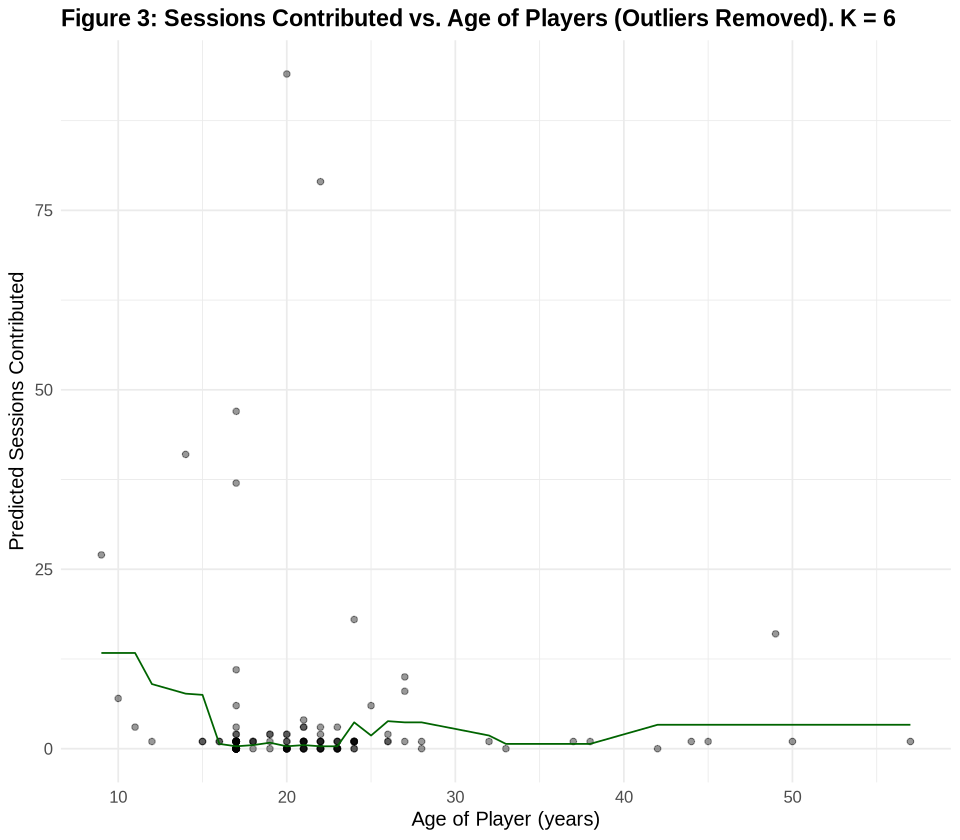

In [25]:
set.seed(5000)

options(repr.plot.width = 8, repr.plot.height = 7)

# use the predict function on the best-k workflow to make predictions for our training data
outlier_preds <- outlier_best_fit |>
    predict(outlier_training) |>
    bind_cols(outlier_training)

# make a scatterplot of the data and plot the predictions over the data points.
outlier_plot <- outlier_preds |>
    ggplot(aes(x = Age, y = num_sessions)) +

    geom_point(alpha = 0.4) +

    geom_line(aes(x = Age, y = .pred), color = "dark green") + 

    labs(y = "Predicted Sessions Contributed", 
         x = "Age of Player (years)", 
         title = paste0("Figure 3: Sessions Contributed vs. Age of Players (Outliers Removed). K = ", outlier_k_min)) +
         theme_minimal() +
  theme(
    plot.title = element_text(size = 14, face = "bold"),
    axis.title = element_text(size = 12),
    axis.text = element_text(size = 10)
  )

outlier_plot

### KNN Plot with Scaled Y-Axis

Looking Figure 3, it is clear that there is a lot of data grouped near y = 0, which makes it hard to determine a trend and make accurate predictions. To account for this, we will take the same analysis and visualization, but scale the y-axis logarithmically.

Warning message in scale_y_log10():
“log-10 transformation introduced infinite values.”


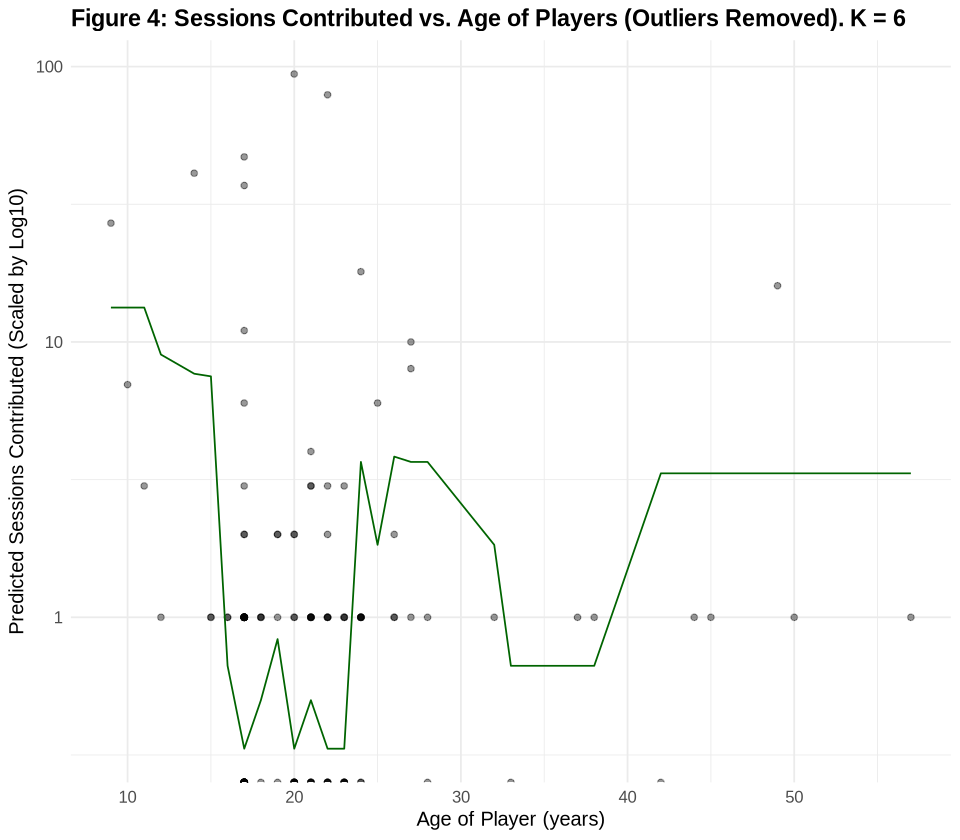

In [26]:
set.seed(5000)

options(repr.plot.width = 8, repr.plot.height = 7)

outlier_plot_scaled <- outlier_preds |>
    ggplot(aes(x = Age, y = num_sessions)) +

    geom_point(alpha = 0.4) +

# scale y-axis
    scale_y_log10() +

    geom_line(aes(x = Age, y = .pred), color = "dark green") + 

    labs(y = "Predicted Sessions Contributed (Scaled by Log10)", 
         x = "Age of Player (years)", 
         title = paste0("Figure 4: Sessions Contributed vs. Age of Players (Outliers Removed). K = ", outlier_k_min)) +
         theme_minimal() +
  theme(
    plot.title = element_text(size = 14, face = "bold"),
    axis.title = element_text(size = 12),
    axis.text = element_text(size = 10)
  )

outlier_plot_scaled

The scaled y-axis visualization provides a clearer picture. However, the prediction line in the visualization is still not consistent, demonstrating the poor fitting of the model due to high variability in the data. Increasing the k-value further causes the model to "choose" a very high k-value where almost the entire data set is being considered as a neighbor. Therefore, a higher k would not improve predictions, so we will use the selected k = 6, despite the poor fitting.

### Analysis with Narrow Scope

We also want to consider a more narrow range of data to see if there is a different trend. We perform the same analysis as above, but with the data filtered to an age range between 10 and 30 years old, where most of the data points are concentrated, as shown in Figure 2.

In [16]:
outlier_data |>
count(Age < 30 & Age > 10)

Age < 30 & Age > 10,n
<lgl>,<int>
FALSE,16
TRUE,173


This will exclude an additional 16 players from our data set, in addition to those considered as outliers.

In [17]:
set.seed(5000)

low_age_data <- outlier_data |>
    filter(Age < 30) |>
    filter(Age > 10) 

low_age_split <- initial_split(low_age_data, prop = 0.75, strata = num_sessions)
low_age_training <- training(low_age_split)
low_age_testing <- testing(low_age_split)

low_age_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |> 
      set_engine("kknn") |>
      set_mode("regression")

low_age_recipe <- recipe(num_sessions ~ Age, data = low_age_training) |>
      step_scale(all_predictors()) |>
      step_center(all_predictors())

low_age_vfold <- vfold_cv(low_age_training, v = 5, strata = num_sessions)

low_age_workflow <- workflow() |>
    add_recipe(low_age_recipe) |>
    add_model(low_age_spec)

low_age_gridvals <- tibble(neighbors = seq(from = 1, to = 50, by = 1))

low_age_results <- low_age_workflow |>
    tune_grid(resamples = low_age_vfold, grid = low_age_gridvals) |>
    collect_metrics() 

low_age_min <- low_age_results |>
   filter(.metric == "rmse") |>
   slice_min(mean, n = 1)

low_age_k_min <- low_age_min |>
         pull(neighbors)

low_age_best_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = low_age_k_min) |>
         set_engine("kknn") |>
         set_mode("regression")

low_age_best_fit <- workflow() |>
         add_recipe(low_age_recipe) |>
         add_model(low_age_best_spec) |>
         fit(data = low_age_training)

low_age_summary <- low_age_best_fit |>
          predict(low_age_testing) |>
          bind_cols(low_age_testing) |>
          metrics(truth = num_sessions, estimate = .pred)

paste0("k = ", low_age_k_min)
low_age_summary

[1] "k = 36"

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
rmse,standard,6.364115342
rsq,standard,0.008864009
mae,standard,2.952020202


Reducing the age range of the data set from all ages to players aged between 10 and 30 raised the RMSE to 6.36. This demonstrates increased variability and will not show improvement in our prediction model.

Warning message in scale_y_log10():
“log-10 transformation introduced infinite values.”


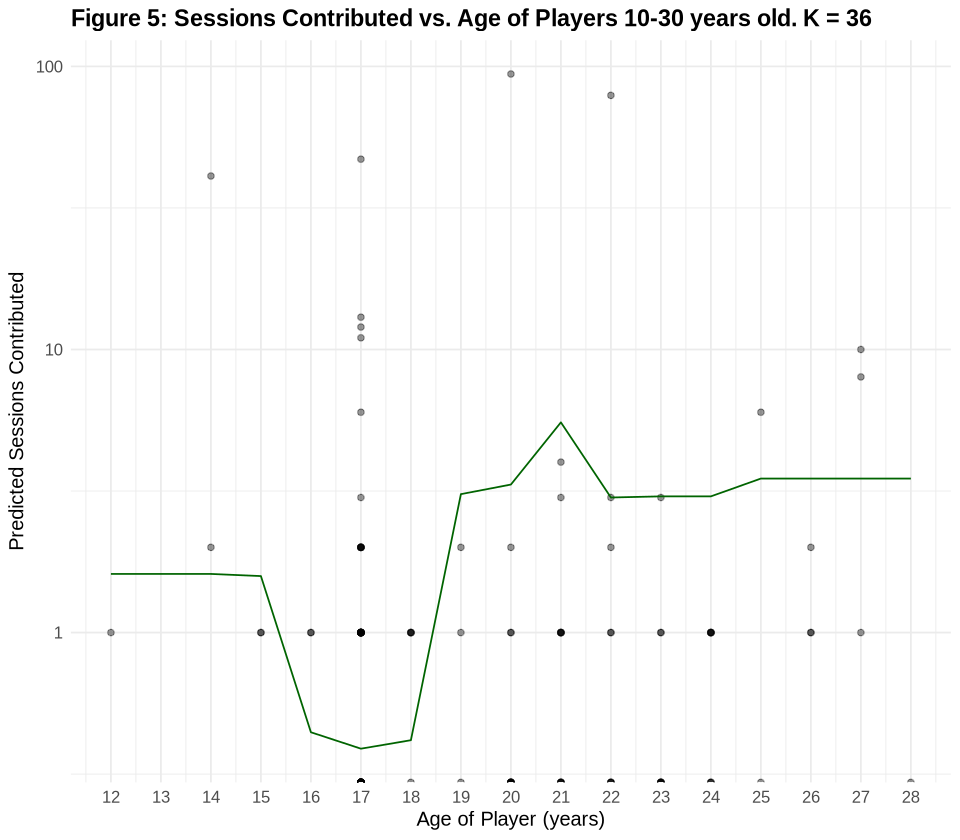

In [21]:
set.seed(5000)

options(repr.plot.width = 8, repr.plot.height = 7)

low_age_preds <- low_age_best_fit |>
    predict(low_age_training) |>
    bind_cols(low_age_training)

low_age_plot <- low_age_preds |>
    ggplot(aes(x = Age, y = num_sessions)) +

    geom_point(alpha = 0.4) +

    scale_y_log10() +

    geom_line(aes(x = Age, y = .pred), color = "dark green") + 

    scale_x_continuous(breaks = seq(10, 30, by = 1)) +

    labs(y = "Predicted Sessions Contributed", 
         x = "Age of Player (years)", 
         title = paste0("Figure 5: Sessions Contributed vs. Age of Players 10-30 years old. K = ", low_age_k_min)) +
         theme_minimal() +
  theme(
    plot.title = element_text(size = 14, face = "bold"),
    axis.title = element_text(size = 12),
    axis.text = element_text(size = 10)
  )

low_age_plot

Even when we limited our data by removing potential outliers (num_sessions < 100) and narrowing our age range to 10-30 years old, the model does not show a clear visual predictor of contribution. This may be due to the high concentration of a low number of session contributions (<5) across all ages and the overall variability of the data set.

## Discussion
### Findings Summary
Using a k-nearest neighbors regression model with K = 6 and removing 5 outliers, we examined how a player's age relates to their predicted number of contributed sessions. We found that predicted sessions contributed was variable and did not show a consistent trend, but stayed at mostly low values across ages, as seen in Figure 4. Players below age 15 are expected to contribute around 10 to 20 sessions. Players above age 15 can be expected to contribute 0 to 5 sessions. However, we can visually see in Figure 4 that there are many players contributed 0 sessions and a few contributing 10 or more, which could be skewing averages used in the regression model. Additionally, Figure 2 demonstrates that older players are less likely to participate, so the data for low-age players is more comprehensive and may have a greater influence on results. Specifically examining data of low-age players between the ages of 10 and 30, where the majority of the data is concentrated, revealed that players aged 19 to 30 may be more likely to contribute around 5 sessions, while players aged 10 to 18 contribute less than 5, as visualized in Figure 5.

### Expected Findings
Based upon Figure 2, we found that people under 25 years old were more likely to participate in the study in general, so a greater number of sessions contributed may have been expected from that age range. Additionally, in Figure 1 there appeared to be no significant trends between the number of sessions and age of players, so we predicted that our results may be inconclusive. This prediction appeared consistent through our data analysis due to an initially high RMSE. However, removing outliers lowered the RMSE and revealed a trend, though with some variability. It was found initially in table 1 that there was a very low negative correlation between age and sessions. This indicated that age is likely not a strong influence of individuals sessions contributed. We also saw a large portion had zero sessions (37%), while a small group of players were highly comitted and had many sessions played. These inital observations influenced us to expect a weak relationship between age and session count.    

### Discussing Potential Impacts of Findings
A potential impact of these findings is that we now know the research group does not need to focus on targeting any specific age group. This means that they should focus on other potential factors for recruitment, such as experience level or gender. 

### Future Questions
Future questions this finding couold lead to are:
1. Is there potential patterns worth exploring in sessions logged by players over the age of 30?
2. To increase the number of data points/observations amongst the ages of Figure 2 where there is a lack of data points, should the research group be targetting those age groups? (ex. 30+ years)

## GitHub Link
https://github.com/glarson5/dsci-100-group-project.git